In [1]:
import numpy as np
import math
import pandas as pd

from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import norm, expon, gamma, binom, kstwobign, kstest
from statsmodels.stats.proportion import proportion_confint

In [2]:
sns.set()

> **Задача**
>
> Первая выборка — артериальное давление контрольной группы (набора пациентов, которым вводилось плацебо). Вторая выборка — артериальное давление тестовой группы (набора пациентов, которым вводилось лекарство). Нужно проверить, влияет ли вводимое лекарство на артериальное давление?

Можно решить задачу сравнения средних с помощью T-test, но это не отвечает на вопрос, так как даже в случае равенства средних, лекарство могло повлиять на давление - у кого-то оно могло повыситься, у кого-то понизиться

Формализуем задачи

Пусть есть 2 реализации выборки: 
- $x_1, \dots, x_n$: реализация выборки $X$ случайных величин $X_1, \dots, X_n$, каждая из которых распределена как $\mathcal{P}_X$.
- $y_1, \dots, y_m$: реализация выборки $Y$ случайных величин $Y_1, \dots, Y_m$, каждая из которых распределена как $\mathcal{P}_Y$.

Критерий согласия проверяет равенство истинных распределений:

 - $H_0: \mathcal{P}_X = \mathcal{P}_Y$
 - $H_1: \mathcal{P}_X \neq \mathcal{P}_Y$.
 
Либо, аналогично, равенство их функций распределения:

 - $H_0: F_X = F_Y$
 - $H_1: F_X \neq F_Y$.

Можно рассмотреть два подхода к тому как устроены выборки $X_i$ и $Y_j$: либо все случайные величины в совокупности независимы, либо есть парная зависимость $X_i$ и $Y_i$.    
- Первый случай получается, когда мы генеральную совокупность делим на две группы, одна из которых подвергается воздействию, а другая нет.  
- Второй случай получается, если мы сначала замеряем метрику у всей генеральной совокупности, потом всю её подвергаем воздействию и снова замеряем   

Приведённый ниже критерий актуален только для первого случая

Задача очень похожа на простую гипотезу согласия, когда нужно сравнить выборку с некоторым распределением. В случае непрерывной фр мы научились решать ту задачу, для решения мы смотрели следующую статистику   
$$
    D_n = \underset{x \in \mathbb{R}}{\sup} |\widehat{{F_X}_n}(x) - F_0(x)|
$$ 

Так как в нашей задаче, функции $F_0$ у нас нет, будем рассматривать следующую статистику $$D_{nm} = \underset{x \in \mathbb{R}}{\sup} |\widehat{{F_X}_n}(x) - \widehat{{F_Y}_m}(x)|$$ 

In [3]:
def calc_Fn(sample, x):
    """
        Функция строит эмпирическую функцию распределения по sample для Fn(x).
    """
    
    return np.mean(sample <= x)

In [4]:
x_axis = np.arange(-3, 3, step=0.001)
n = len(x_axis)

X_size = 100
Y_size = 83

X = norm(loc=0, scale=1).rvs(X_size)
Y = norm(loc=0, scale=1).rvs(Y_size)

emp_cdf_X, emp_cdf_Y = np.empty(n), np.empty(n)
for i, x in tqdm(enumerate(x_axis)):
    emp_cdf_X[i] = calc_Fn(X, x)
    emp_cdf_Y[i] = calc_Fn(Y, x)

6000it [00:00, 54198.49it/s]


Text(0, 0.5, 'Prob')

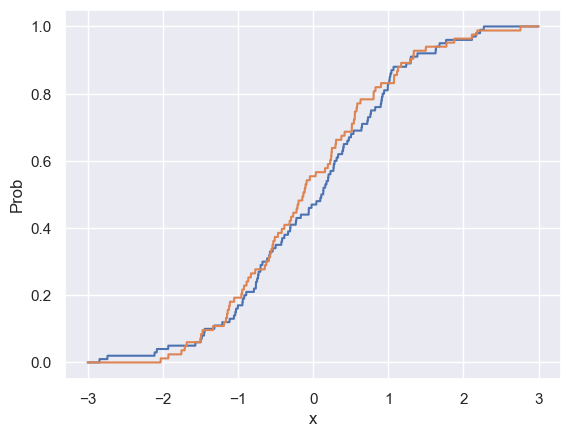

In [5]:
fig, ax = plt.subplots()

ax.plot(x_axis, emp_cdf_X, label='Эмпирическая функция для X')
ax.plot(x_axis, emp_cdf_Y, label='Эмпирическая функция для Y')
ax.set_xlabel('x')
ax.set_ylabel('Prob')

In [4]:
def get_Dnm_stat(emp_cdf_X, emp_cdf_Y):
    return(np.max(np.abs(emp_cdf_X - emp_cdf_Y)))

In [7]:
x_axis = np.arange(-3, 3, step=0.01)
n = len(x_axis)

N_exps = 10000
Dnm = np.empty(N_exps)

X_size = 100
Y_size = 87

for j in tqdm(range(N_exps)):
    X = norm(loc=0, scale=1).rvs(X_size)
    Y = norm(loc=0, scale=1).rvs(Y_size)

    emp_cdf_X, emp_cdf_Y = np.empty(n), np.empty(n)

    for i, x in enumerate(x_axis):
        emp_cdf_X[i] = calc_Fn(X, x)
        emp_cdf_Y[i] = calc_Fn(Y, x)
    
    Dnm[j] = get_Dnm_stat(emp_cdf_X, emp_cdf_Y)
    

100%|██████████| 10000/10000 [02:07<00:00, 78.37it/s]


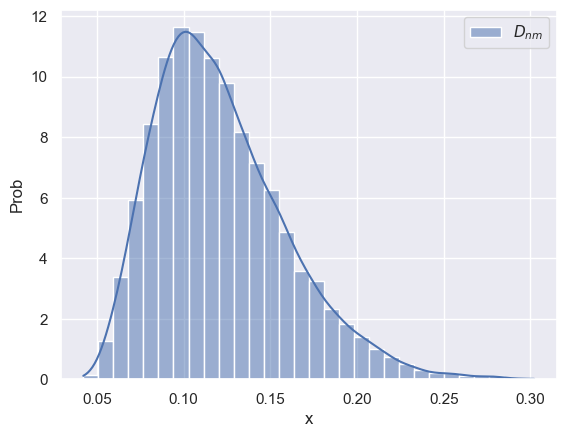

In [8]:
fig, ax = plt.subplots()

sns.histplot(Dnm, ax=ax, kde=True, stat='density', bins=30, label=r'$D_{nm}$')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('Prob');

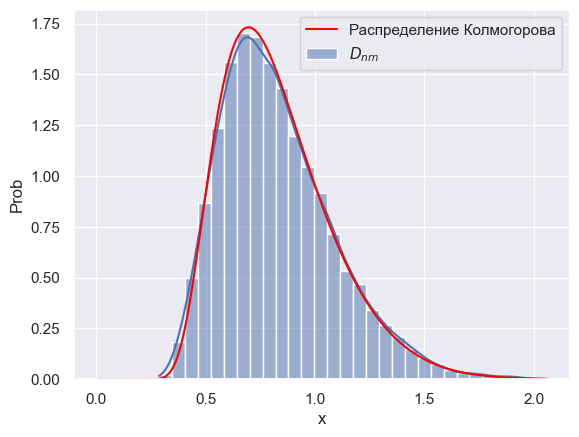

In [56]:
fig, ax = plt.subplots()

sns.histplot(np.sqrt(X_size * Y_size / (X_size + Y_size)) * Dnm, kde=True, ax=ax, stat='density', bins=30, label=r'$D_{nm}$')

right = (np.sqrt(X_size * Y_size / (X_size + Y_size)) * Dnm).max()
ax.plot(np.linspace(0, right, 1000), kstwobign.pdf(np.linspace(0, right, 1000), loc=-0.02, scale=0.974), color='red', label='Распределение Колмогорова')
ax.set_xlabel('x')
ax.set_ylabel('Prob')
ax.legend();

Итого, на графике выше видно, что статистика $\sqrt\frac{nm}{m+n} D_{mn}$ похоже имеет распределение Колмогорова(разве что немного сдвинутое и сжатое), проверим это гипотезу с помощью критерия Колмогорова

In [57]:
Dn, p = kstest(rvs=np.sqrt(X_size * Y_size / (X_size + Y_size)) * Dnm, cdf=lambda x: kstwobign.cdf(x=x, loc=-0.02, scale=0.974))
print(f'p-value: {p:.4f}')

p-value: 0.3649


Формально, этот факт называется теоремой Колмогорова-Смирнова, утверждающей что если   
1. Случайные величины $X_1, X_2, \dots, X_n$ независимы и имеют общую функцию распределения $F_X$.
2. Случайные величины $Y_1, Y_2, \dots, Y_m$ независимы и имеют общую функцию распределения $F_Y$.
3. Функции распределения $F_X$ и $F_Y$ неизвестны, но принадлежат множеству всех **непрерывных функций распределения**.
4. Все компоненты случайного вектора ($X_1, \dots, X_n, Y_1, \dots, Y_m$) **независимы** (условие, которое мы обсудили в разделе "Два вида однородности").

А также при выполнении нулевой гипотезы $H_0: F_X = F_Y$ имеет место следующее поведение статистики на бесконечности 

$$\sqrt\frac{nm}{m+n} D_{mn} \stackrel{d}{\rightarrow} K$$ 

где K - с.в. с распределением Колмогорова

Итого, можно сформулировать следующее правило:

> Если статистика $\sqrt {\frac {nm}{m+n}}D_{mn}$ превышает квантиль распределения Колмогорова $K_{\alpha}$ для заданного уровня значимости $\alpha$ и достаточно больших $n$ и $m$, то нулевая гипотеза $H_0$ об однородности выборок отвергается на уровне значимости $\alpha$.

Ну или, если формулировать правило вычисления p-value, то p_value = 1 - ks.cdf(stat)

Проверим корректность критерия с помощью метода Монте-Карло

In [5]:
def check_criterion(n, m, alpha, dist_X, dist_Y, crit, N_exps=10_000):
    
    positive=0

    for i in tqdm(range(N_exps), leave=False):
        sample_X = dist_X.rvs(n)
        sample_Y = dist_Y.rvs(m)

        pval = crit(sample_X, sample_Y)

        positive += (pval < alpha)

    rate = positive / N_exps
    left, right = proportion_confint(count = positive, nobs = N_exps, alpha=alpha, method='wilson')

    return rate, left, right

In [6]:
crit = lambda sample_X, sample_Y: kstest(sample_X, sample_Y).pvalue

In [35]:
fpr, left, right = check_criterion(
    n=1500,
    m=1300,
    alpha=0.05,
    dist_X=norm(),
    dist_Y=norm(),
    crit=crit
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0481
FPR confint:  (0.04407686215956089, 0.052470195567856606)


In [99]:
fpr, left, right = check_criterion(
    n=500,
    m=300,
    alpha=0.05,
    dist_X=gamma(a=3),
    dist_Y=gamma(a=3),
    crit=crit
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

100%|██████████| 10000/10000 [00:07<00:00, 1324.38it/s]

FPR:  0.0486
FPR confint:  (0.04455606550831664, 0.05299060822073017)


In [100]:
fpr, left, right = check_criterion(
    n=50,
    m=30,
    alpha=0.05,
    dist_X=expon(loc=10, scale=4),
    dist_Y=expon(loc=10, scale=4),
    crit=crit
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

100%|██████████| 10000/10000 [00:05<00:00, 1809.44it/s]

FPR:  0.0483
FPR confint:  (0.04426852864460951, 0.05267837548345972)


In [102]:
fpr, left, right = check_criterion(
    n=20,
    m=20,
    alpha=0.05,
    dist_X=norm(),
    dist_Y=norm(),
    crit=crit,
    N_exps=20_000
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

100%|██████████| 20000/20000 [00:11<00:00, 1750.79it/s]

FPR:  0.03495
FPR confint:  (0.032492727630530155, 0.037585885105252764)


In [105]:
fpr, left, right = check_criterion(
    n=20,
    m=15,
    alpha=0.05,
    dist_X=norm(),
    dist_Y=norm(),
    crit=crit,
    N_exps=20_000
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

100%|██████████| 20000/20000 [00:11<00:00, 1734.83it/s]

FPR:  0.04655
FPR confint:  (0.043716336085480374, 0.04955782141380092)


In [103]:
fpr, left, right = check_criterion(
    n=20,
    m=20,
    alpha=0.05,
    dist_X=gamma(a=3),
    dist_Y=gamma(a=3),
    crit=crit,
    N_exps=20_000
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

100%|██████████| 20000/20000 [00:10<00:00, 1845.45it/s]

FPR:  0.03275
FPR confint:  (0.030371680745774544, 0.03530777694865523)


In [106]:
fpr, left, right = check_criterion(
    n=20,
    m=15,
    alpha=0.05,
    dist_X=gamma(a=3),
    dist_Y=gamma(a=3),
    crit=crit,
    N_exps=20_000
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

100%|██████████| 20000/20000 [00:14<00:00, 1363.81it/s]

FPR:  0.0462
FPR confint:  (0.043376858902333025, 0.049197433022187535)


Тест показывает, что на выборках разного размера критерий показывает себя хорошо даже при малом их объёме, но на маленьких выборках одинакого размера FPR становится очень низким(пусть критерий и остаётся корректным), найдём минимальный размер выборки, при котором FPR примерно равен 5%

In [10]:
numpy_ceil = np.vectorize(math.ceil)

In [115]:
FPR_list = []

# перебираем размер выборки с логарифмическим шагом
for i in tqdm(numpy_ceil(np.geomspace(10, 3000, 10))):  
    mmk_res = check_criterion(
        n=i,
        m=i,
        alpha=0.05,
        dist_X=gamma(a=3),
        dist_Y=gamma(a=3),
        crit=crit,
        N_exps=20_000
    )
    FPR_list.append([i, mmk_res])

100%|██████████| 10/10 [03:03<00:00, 18.30s/it]


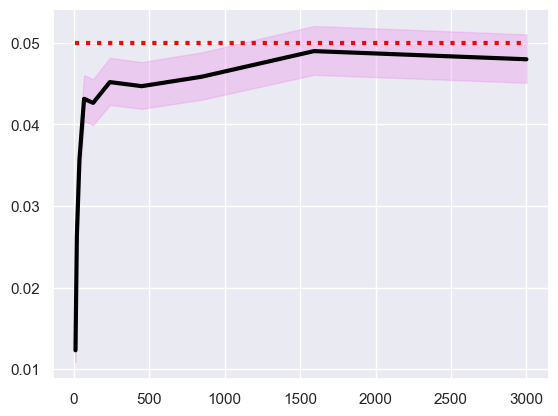

In [122]:
fig, ax = plt.subplots()

ax.plot(
    [elem[0] for elem in FPR_list],
    [elem[1][0] for elem in FPR_list],
    color='black',
    linewidth=3.0,
    label='FPR'
)

ax.fill_between(
    [elem[0] for elem in FPR_list],
    [elem[1][1] for elem in FPR_list],
    [elem[1][2] for elem in FPR_list],
    color='violet',
    alpha=0.3,
    label='FPR confint'
)

ax.plot(
    [elem[0] for elem in FPR_list],
    np.array([0.05] * len(FPR_list)),
    color='red',
    linestyle=':',
    linewidth=3.0,
    label='alpha'
)

Теперь поисследуем мощность

In [6]:
tpr, left, right = check_criterion(
    n=1500,
    m=1300,
    alpha=0.05,
    dist_X=norm(loc=0, scale=1),
    dist_Y=norm(loc=0.1, scale=1),
    crit=crit
)

print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.6197
TPR confint:  (0.6101409001495313, 0.6291671706405289)


In [7]:
class NoiseRv(stats.rv_continuous):
    def __init__(self, base_dist, noise_dist, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.base_dist = base_dist
        self.noise_dist = noise_dist

    def rvs(self, size=None, random_state=None):
        base_sample = self.base_dist.rvs(size=size, random_state=random_state)
        noise_sample = self.noise_dist.rvs(size=size, random_state=random_state)

        return base_sample + noise_sample

In [21]:
tpr, left, right = check_criterion(
    n=1000,
    m=900,
    alpha=0.05,
    dist_X=norm(loc=0, scale=1),
    dist_Y=NoiseRv(norm(loc=0, scale=1), norm(loc=0, scale=0.7)),
    crit=crit
)

print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.7516
TPR confint:  (0.7430357507418971, 0.7599710212779786)


In [22]:
tpr, left, right = check_criterion(
    n=1000,
    m=1000,
    alpha=0.05,
    dist_X=norm(loc=0, scale=1),
    dist_Y=NoiseRv(norm(loc=0, scale=1), norm(loc=0, scale=0.7)),
    crit=crit
)

print('TPR: ', tpr)
print('TPR confint: ', (left, right))

TPR:  0.4866
TPR confint:  (0.4768107253095301, 0.49639956584680384)


In [25]:
TPR_list = []

for i in tqdm(numpy_ceil(np.geomspace(50, 4000, 8))):
    mmk_res = check_criterion(
        n=i,
        m=i,
        alpha=0.05,
        dist_X=norm(loc=0, scale=1),
        dist_Y=NoiseRv(norm(loc=0, scale=1), norm(loc=0.1, scale=0.3)),
        crit=crit
    )
    TPR_list.append([i, mmk_res])

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [01:41<00:00, 12.73s/it]


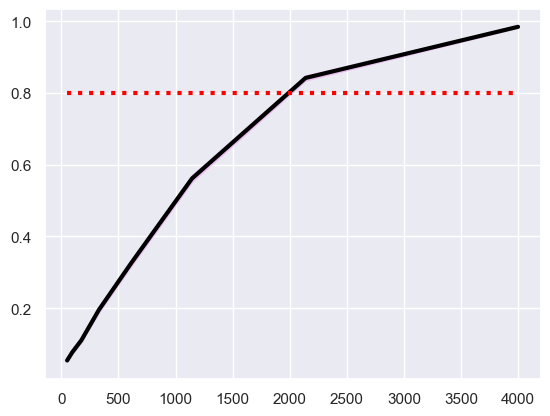

In [30]:
fig, ax = plt.subplots()

ax.plot(
    [elem[0] for elem in TPR_list],
    [elem[1][0] for elem in TPR_list],
    color='black',
    linewidth=3.0,
    label='FPR'
)

ax.fill_between(
    [elem[0] for elem in TPR_list],
    [elem[1][1] for elem in TPR_list],
    [elem[1][2] for elem in TPR_list],
    color='violet',
    alpha=0.3,
    label='FPR confint'
)

ax.plot(
    [elem[0] for elem in TPR_list],
    np.array([0.8] * len(TPR_list)),
    color='red',
    linestyle=':',
    linewidth=3.0,
    label='alpha'
)

Теорема ничего не может сказать про выборки с зависимыми наблюдениями, попробуем ответить на этот вопрос эмпирически

In [8]:
def check_criterion_dep(n, init_dist, noise_dist_X, noise_dist_Y, crit, alpha=0.05, N_exps=10000):
    positive = 0

    for i in tqdm(range(N_exps), leave=False):
        init_sample = init_dist.rvs(n)
        noise_sample_X = noise_dist_X.rvs(n)
        noise_sample_Y = noise_dist_Y.rvs(n)

        pval = crit(init_sample + noise_sample_X, init_sample + noise_sample_Y)

        positive += (pval <= alpha)
    
    rate = positive / N_exps
    left, right = proportion_confint(count=positive, nobs=N_exps, alpha=alpha, method='wilson')

    return rate, left, right

Рассмотрим случай, когда шума вообще нет, то есть выборки X и Y идентичны

In [38]:
fpr, left, right = check_criterion_dep(
    n=100,
    init_dist=norm(),
    noise_dist_X=norm(0, 0),
    noise_dist_Y=norm(0, 0),
    crit=crit
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0
FPR confint:  (0.0, 0.0003839983706765959)


Ожидаемо, критерий никогда не отвергает гипотезу, так как эмпирические функции абсолютно идентичны

А если шум не равен нулю, но распраделён одинаково

In [42]:
fpr, left, right = check_criterion_dep(
    n=600,
    init_dist=norm(0, 4),
    noise_dist_X=norm(0, 3),
    noise_dist_Y=norm(0, 3),
    crit=crit
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0041
FPR confint:  (0.003023854656345703, 0.005556994927691345)


In [41]:
fpr, left, right = check_criterion_dep(
    n=600,
    init_dist=norm(0, 3),
    noise_dist_X=norm(0, 4),
    noise_dist_Y=norm(0, 4),
    crit=crit
)

print('FPR: ', fpr)
print('FPR confint: ', (left, right))

FPR:  0.0146
FPR confint:  (0.012428583359981107, 0.01714420225827173)


Видим, что fpr всё ещё довольно близок к нулю, нарисуем эмпирическое распределение чтобы понять что на самом деле происходит

In [58]:
x_axis = np.arange(-3, 3, step=0.001)
n = len(x_axis)

sample_size = 600

init_sample = norm(0, 4).rvs(sample_size)
X = norm(0, 3).rvs(sample_size) + init_sample
Y = norm(0, 3).rvs(sample_size) + init_sample

emp_cdf_X, emp_cdf_Y = np.empty(n), np.empty(n)
for i, x in tqdm(enumerate(x_axis)):
    emp_cdf_X[i] = calc_Fn(X, x)
    emp_cdf_Y[i] = calc_Fn(Y, x)

6000it [00:00, 48129.07it/s]


Text(0, 0.5, 'Prob')

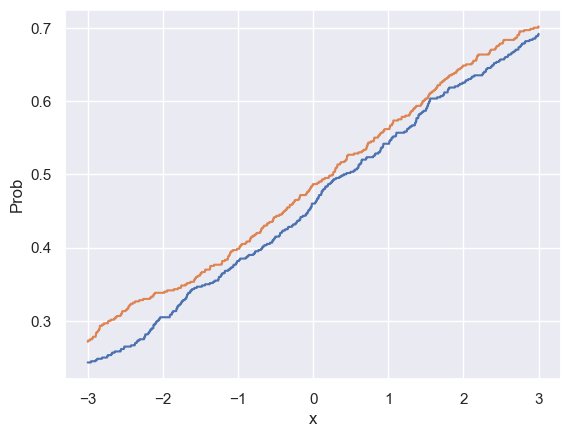

In [59]:
fig, ax = plt.subplots()

ax.plot(x_axis, emp_cdf_X, label='Эмпирическая функция для X')
ax.plot(x_axis, emp_cdf_Y, label='Эмпирическая функция для Y')
ax.set_xlabel('x')
ax.set_ylabel('Prob')

In [60]:
x_axis = np.arange(-3, 3, step=0.01)
n = len(x_axis)

N_exps = 10000
sample_size = 600

Dnm = np.empty(N_exps)

for j in tqdm(range(N_exps)):
    init_sample = norm(0, 4).rvs(sample_size)
    X = norm(0, 3).rvs(sample_size) + init_sample
    Y = norm(0, 3).rvs(sample_size) + init_sample

    emp_cdf_X, emp_cdf_Y = np.empty(n), np.empty(n)
    for i, x in enumerate(x_axis):
        emp_cdf_X[i] = calc_Fn(X, x)
        emp_cdf_Y[i] = calc_Fn(Y, x)

    Dnm[j] = get_Dnm_stat(emp_cdf_X, emp_cdf_Y)

100%|██████████| 10000/10000 [02:45<00:00, 60.50it/s]


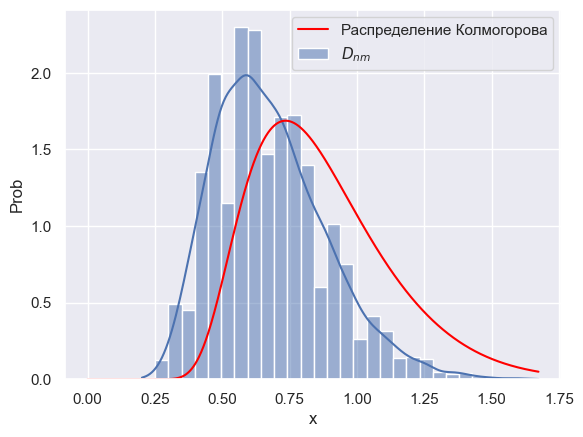

In [61]:
fig, ax = plt.subplots()

sns.histplot(np.sqrt(sample_size * sample_size / (sample_size + sample_size)) * Dnm, kde=True, ax=ax, stat='density', bins=30, label=r'$D_{nm}$')

right = (np.sqrt(sample_size * sample_size / (sample_size + sample_size)) * Dnm).max()
ax.plot(np.linspace(0, right, 1000), kstwobign.pdf(np.linspace(0, right, 1000)), color='red', label='Распределение Колмогорова')
ax.set_xlabel('x')
ax.set_ylabel('Prob')
ax.legend();

Из этих графиков ясно чем обусловлен такой низкий fpr - просто статистика в данном случае имеет не распределение Колмогорова, но при этом критерий остаётся корректным (просто маломощным)

Теперь сравним FPR критерия для независимых выборок, и для зависимых

In [14]:
FPR_list_independent = []
FPR_list_dependent1 = []
FPR_list_dependent2 = []

for i in tqdm(numpy_ceil(np.geomspace(50, 6000, 10))):
    res_indep = check_criterion(
        n=i // 2,
        m=i // 2,
        alpha=0.05,
        dist_X=norm(0, 5),
        dist_Y=norm(0, 5),
        crit=crit,
        N_exps=10_000
    )
    res_dep1 = check_criterion_dep(
        n=i,
        init_dist=norm(0, 4),
        noise_dist_X=norm(0, 3),
        noise_dist_Y=norm(0, 3),
        crit=crit
    )
    res_dep2 = check_criterion_dep(
        n=i,
        init_dist=norm(0, 3),
        noise_dist_X=norm(0, 4),
        noise_dist_Y=norm(0, 4),
        crit=crit
    )


    FPR_list_independent.append([i, res_indep])
    FPR_list_dependent1.append([i, res_dep1])
    FPR_list_dependent2.append([i, res_dep2])

100%|██████████| 10/10 [05:30<00:00, 33.09s/it]


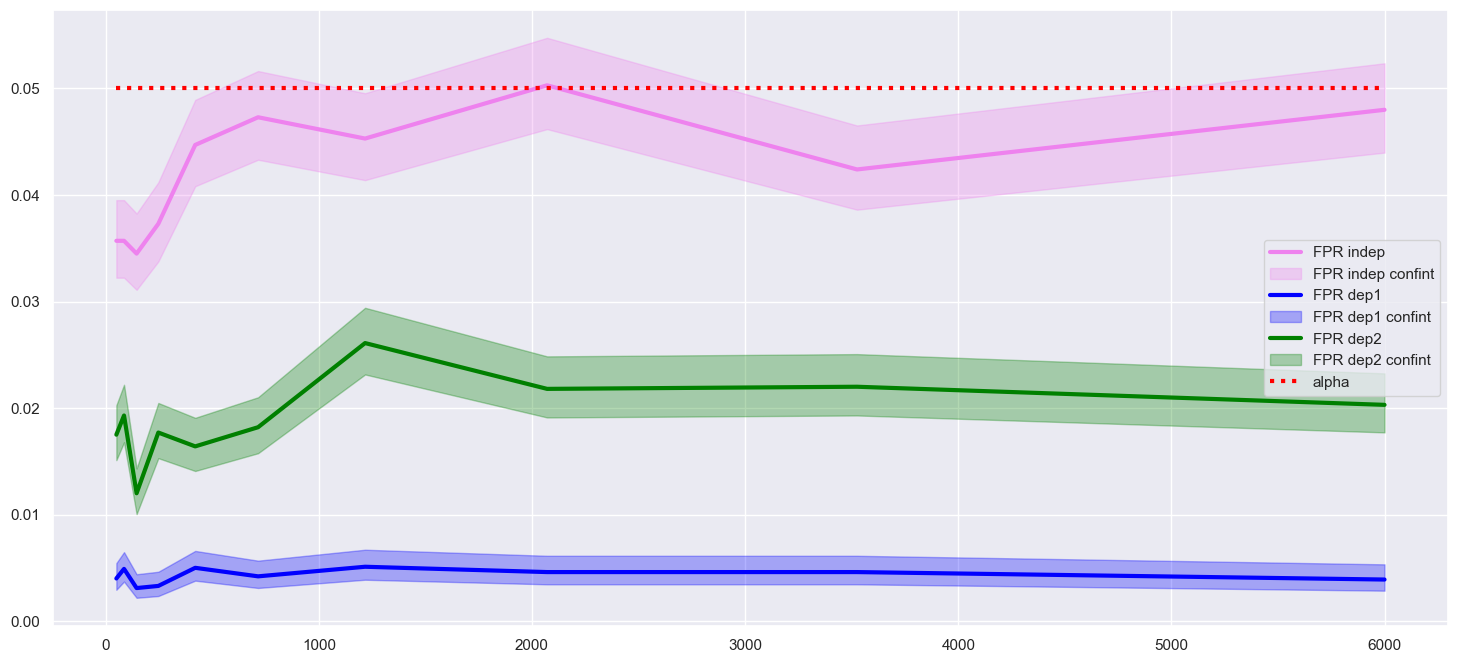

In [20]:
fig, ax = plt.subplots(figsize=(18, 8))

#FPR_independent
ax.plot(
    [elem[0] for elem in FPR_list_independent],
    [elem[1][0] for elem in FPR_list_independent],
    color='violet',
    linewidth=3.0,
    label='FPR indep'
)
ax.fill_between(
    [elem[0] for elem in FPR_list_independent],
    [elem[1][1] for elem in FPR_list_independent],
    [elem[1][2] for elem in FPR_list_independent],
    color='violet',
    alpha=0.3,
    label='FPR indep confint'
)

# #FPR_dependent1
ax.plot(
    [elem[0] for elem in FPR_list_dependent1],
    [elem[1][0] for elem in FPR_list_dependent1],
    color='blue',
    linewidth=3.0,
    label='FPR dep1'
)
ax.fill_between(
    [elem[0] for elem in FPR_list_dependent1],
    [elem[1][1] for elem in FPR_list_dependent1],
    [elem[1][2] for elem in FPR_list_dependent1],
    color='blue',
    alpha=0.3,
    label='FPR dep1 confint'
)

#FPR_dependent2
ax.plot(
    [elem[0] for elem in FPR_list_dependent2],
    [elem[1][0] for elem in FPR_list_dependent2],
    color='green',
    linewidth=3.0,
    label='FPR dep2'
)
ax.fill_between(
    [elem[0] for elem in FPR_list_dependent2],
    [elem[1][1] for elem in FPR_list_dependent2],
    [elem[1][2] for elem in FPR_list_dependent2],
    color='green',
    alpha=0.3,
    label='FPR dep2 confint'
)

ax.plot(
    [elem[0] for elem in FPR_list_independent],
    np.array([0.05] * len(FPR_list_independent)),
    color='red',
    linestyle=':',
    linewidth=3.0,
    label='alpha'
)

ax.legend()

Видим что для зависимых выборок FPR очень низкий даже для больших выборок, но что же с мощностью

In [16]:
TPR_list_independent = []
TPR_list_dependent1 = []
TPR_list_dependent2 = []

for i in tqdm(numpy_ceil(np.geomspace(50, 6000, 10))):
    res_indep = check_criterion(
        n=i // 2,
        m=i // 2,
        alpha=0.05,
        dist_X=norm(0, 5),
        dist_Y=norm(0, 2*math.sqrt(5)),
        crit=crit,
        N_exps=10_000
    )
    res_dep1 = check_criterion_dep(
        n=i,
        init_dist=norm(0, 4),
        noise_dist_X=norm(0, 3),
        noise_dist_Y=norm(0, 2),
        crit=crit
    )
    res_dep2 = check_criterion_dep(
        n=i,
        init_dist=norm(0, 3),
        noise_dist_X=norm(0, 4),
        noise_dist_Y=norm(0, math.sqrt(11)),
        crit=crit
    )


    TPR_list_independent.append([i, res_indep])
    TPR_list_dependent1.append([i, res_dep1])
    TPR_list_dependent2.append([i, res_dep2])

100%|██████████| 10/10 [05:20<00:00, 32.09s/it]


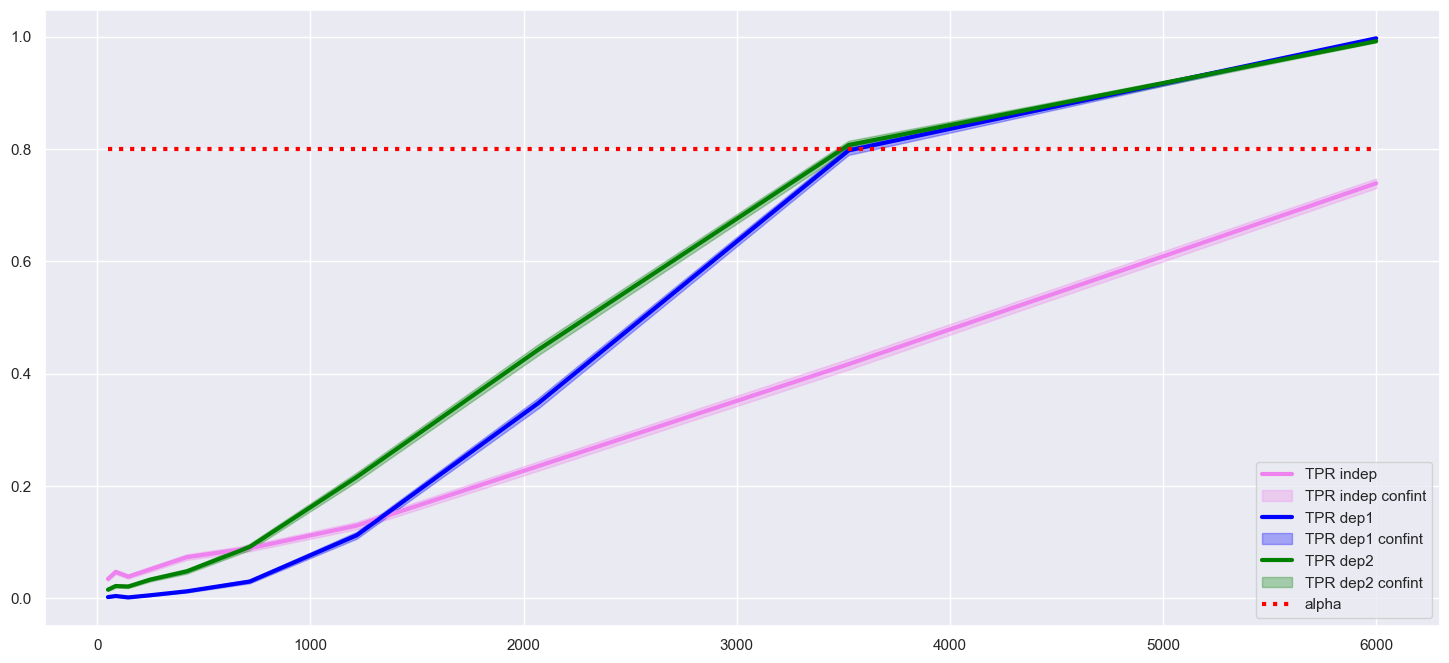

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))

#TPR_independent
ax.plot(
    [elem[0] for elem in TPR_list_independent],
    [elem[1][0] for elem in TPR_list_independent],
    color='violet',
    linewidth=3.0,
    label='TPR indep'
)
ax.fill_between(
    [elem[0] for elem in TPR_list_independent],
    [elem[1][1] for elem in TPR_list_independent],
    [elem[1][2] for elem in TPR_list_independent],
    color='violet',
    alpha=0.3,
    label='TPR indep confint'
)

#TPR_dependent1
ax.plot(
    [elem[0] for elem in TPR_list_dependent1],
    [elem[1][0] for elem in TPR_list_dependent1],
    color='blue',
    linewidth=3.0,
    label='TPR dep1'
)
ax.fill_between(
    [elem[0] for elem in TPR_list_dependent1],
    [elem[1][1] for elem in TPR_list_dependent1],
    [elem[1][2] for elem in TPR_list_dependent1],
    color='blue',
    alpha=0.3,
    label='TPR dep1 confint'
)

#TPR_dependent2
ax.plot(
    [elem[0] for elem in TPR_list_dependent2],
    [elem[1][0] for elem in TPR_list_dependent2],
    color='green',
    linewidth=3.0,
    label='TPR dep2'
)
ax.fill_between(
    [elem[0] for elem in TPR_list_dependent2],
    [elem[1][1] for elem in TPR_list_dependent2],
    [elem[1][2] for elem in TPR_list_dependent2],
    color='green',
    alpha=0.3,
    label='TPR dep2 confint'
)

ax.plot(
    [elem[0] for elem in TPR_list_independent],
    np.array([0.8] * len(TPR_list_independent)),
    color='red',
    linestyle=':',
    linewidth=3.0,
    label='alpha'
)

ax.legend()

Получили удивительный результат: критерий с зависимыми величинами оказался мощнее, чем с независимыми